# BinaryNet on CIFAR-10 Dataset Implemtation

Implementation of [BinaryNet](https://arxiv.org/abs/1602.02830) on the CIFAR-10 dataset, following the original paper.

In [1]:
import tensorflow as tf
import larq as lq
from typing import Tuple

import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os

## Data

We fetch the data using inbuilt Keras datasets to make loading on Colab easier.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 
test images.

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

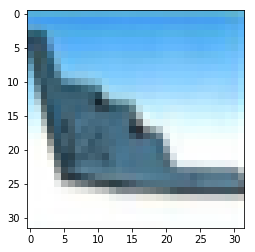

In [10]:
plt.imshow(x_train[1])

# Using the tf.data.Dataset API



In [11]:
def preprocess(image: tf.Tensor, labels: tf.Tensor, training: bool) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Applies preprocessing to images in the ETL pipeline.
    :param image: The input image
    :param labels: The input images label
    :param training: Boolean, True if training, False otherwise
    :returns: The processed image and corresponding label
    """
    image = tf.image.per_image_standardization(image)
    
    # Some transforms we only apply to train data, such as random augmentations to improve learning generalisation
    if training:
        image = tf.image.resize_with_crop_or_pad(image, 40, 40)
        image = tf.image.random_crop(image, (32, 32, 3))
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
    return image, labels

In [12]:
def dataset_generator(data_x: np.ndarray, data_y: np.ndarray, batch_size: int, training: bool) -> tf.data.Dataset:
    """
    Produces a tf.data.Dataset object for a highly optimised data ETL pipeline.
    :param data_x: The input image array
    :param data_y: The corresponding labels
    :param batch_size: The batch size
    :param training: Boolean, True if training, false otherwise
    :return: A tf.data.Dataset object
    """
    labels = tf.one_hot(np.squeeze(data_y), 10)  # Convert the labels to a sparse matrix
    images = tf.cast(data_x, dtype=tf.float16)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))  # Convert to tf.data.Dataset
    
    dataset = dataset.shuffle(data_x.shape[0], reshuffle_each_iteration=True)  # Shuffle the data each epoch
    
    dataset = dataset.map(lambda x, y: preprocess(image=x, labels=y, training=training))  # Apply preprocessing
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2)
    
    return dataset    

In [13]:
train_batch_size = 64
val_batch_size = 128
test_batch_size = 128

In [14]:
train_dataset = dataset_generator(x_train, y_train, batch_size=train_batch_size, training=True)
val_dataset = dataset_generator(x_val, y_val, batch_size=val_batch_size, training=False)
test_dataset = dataset_generator(x_train, y_train, batch_size=test_batch_size, training=False)

W0710 23:11:38.317013 4513134016 deprecation.py:323] From /anaconda3/envs/TensorFlow-2.0/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [15]:
train_dataset

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float16, tf.float32)>

In [16]:
val_dataset

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float16, tf.float32)>

In [17]:
test_dataset

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float16, tf.float32)>

# Building BinaryNet

In [18]:
class BinaryNet(tf.keras.Model):

    def __init__(self, num_classes: int) -> None:
        """
        Builds the BinaryNet model in TensorFlow 2.0 and Larq.
        :param num_classes: The number of output classes
        """
        super(BinaryNet, self).__init__(name='BinaryNet')

        kwargs = {
            'input_quantizer': 'ste_sign',
            'kernel_quantizer': 'ste_sign',
            'kernel_constraint': 'weight_clip',
            'use_bias': False
        }
        # Conv Block 1
        self.conv_1_1 = lq.layers.QuantConv2D(128, 3,
                                              padding='same',
                                              kernel_quantizer='ste_sign',
                                              kernel_constraint='weight_clip',
                                              use_bias=False)
        self.bn_1_1 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)
        self.conv_1_2 = lq.layers.QuantConv2D(128, 3, padding='same', **kwargs)
        self.max_pool_1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        self.bn_1_2 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)

        # Conv Block 2
        self.conv_2_1 = lq.layers.QuantConv2D(256, 3, padding='same', **kwargs)
        self.bn_2_1 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)
        self.conv_2_2 = lq.layers.QuantConv2D(256, 3, padding='same', **kwargs)
        self.max_pool_2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        self.bn_2_2 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)

        # Conv Block 3
        self.conv_3_1 = lq.layers.QuantConv2D(512, 3, padding='same', **kwargs)
        self.bn_3_1 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)
        self.conv_3_2 = lq.layers.QuantConv2D(512, 3, padding='same', **kwargs)
        self.max_pool_3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))
        self.bn_3_2 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)

        # Flatten
        self.flatten_4 = tf.keras.layers.Flatten()

        # FC Block
        self.fc_5 = lq.layers.QuantDense(1024, **kwargs)
        self.bn_5 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)

        # FC Block
        self.fc_6 = lq.layers.QuantDense(1024, **kwargs)
        self.bn_6 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)

        # FC Block
        self.fc_7 = lq.layers.QuantDense(num_classes, **kwargs)
        self.bn_7 = tf.keras.layers.BatchNormalization(momentum=0.999, scale=False)

        # Output
        self.network_output = tf.keras.layers.Softmax()

    def call(self, inputs: tf.Tensor) -> tf.keras.Model:
        """
        Builds the BinaryNet model when called.
        :param inputs: The input tensor
        :return: The built BinaryNet model
        """

        x = self.conv_1_1(inputs)
        x = self.bn_1_1(x)
        x = self.conv_1_2(x)
        x = self.max_pool_1(x)
        x = self.bn_1_2(x)

        x = self.conv_2_1(x)
        x = self.bn_2_1(x)
        x = self.conv_2_2(x)
        x = self.max_pool_2(x)
        x = self.bn_2_2(x)

        x = self.conv_3_1(x)
        x = self.bn_3_1(x)
        x = self.conv_3_2(x)
        x = self.max_pool_3(x)
        x = self.bn_3_2(x)

        x = self.flatten_4(x)

        x = self.fc_5(x)
        x = self.bn_5(x)

        x = self.fc_6(x)
        x = self.bn_6(x)

        x = self.fc_7(x)
        x = self.bn_7(x)

        x = self.network_output(x)

        return x

In [19]:
model = BinaryNet(10)

In [20]:
model.build((None,32,32,3))

In [21]:
model.summary()

Model: "BinaryNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quant_conv2d (QuantConv2D)   multiple                  6914      
_________________________________________________________________
batch_normalization (BatchNo multiple                  384       
_________________________________________________________________
quant_conv2d_1 (QuantConv2D) multiple                  294914    
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
batch_normalization_1 (Batch multiple                  384       
_________________________________________________________________
quant_conv2d_2 (QuantConv2D) multiple                  589826    
_________________________________________________________________
batch_normalization_2 (Batch multiple                  76

In [22]:
lq.models.summary(model)

+BinaryNet stats------------------------------------------------------------+
| Layer                  Input prec.   Outputs   # 1-bit  # 32-bit   Memory |
|                              (bit)                                   (kB) |
+---------------------------------------------------------------------------+
| quant_conv2d                     -  multiple      3456         0     0.42 |
| batch_normalization              -  multiple         0       384     1.50 |
| quant_conv2d_1                   1  multiple    147456         0    18.00 |
| max_pooling2d                    -  multiple         0         0     0.00 |
| batch_normalization_1            -  multiple         0       384     1.50 |
| quant_conv2d_2                   1  multiple    294912         0    36.00 |
| batch_normalization_2            -  multiple         0       768     3.00 |
| quant_conv2d_3                   1  multiple    589824         0    72.00 |
| max_pooling2d_1                  -  multiple         0        

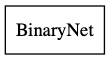

In [23]:
tf.keras.utils.plot_model(model, expand_nested=True)

# Train

In [24]:
os.makedirs('./checkpoints', exist_ok=True)
os.makedirs('./logs', exist_ok=True)

## Optimisers

In [ ]:
initial_lr = 1e-3
var_decay = 1e-5

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=initial_lr, decay=var_decay),
    loss=tf.keras.losses.SquaredHinge(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
trained = model.fit(train_dataset, epochs=10)

In [25]:
initial = 0.01

def scheduler(epoch: int) -> float:
    """
    Computers the updated learning rate for each epoch
    > we decay the learning rate by using a 1-bit right shift every 50 epochs.
    :param epoch: The current epoch
    :return: The updated learning rate
    """
    batch = epoch // 50
    multiplier = 0.1**batch
    return initial * multiplier

In [26]:
optimiser = tf.keras.optimizers.Adam(learning_rate=initial, decay=1e-5)

In [27]:
model.compile(
    optimizer=optimiser,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), 
             tf.keras.metrics.TopKCategoricalAccuracy()]
)

## Initialise Callbacks

In [28]:
callbacks = [
    lq.callbacks.
    tf.keras.callbacks.EarlyStopping(patience=50),
    tf.keras.callbacks.ModelCheckpoint('./checkpoints', save_best_only=True),
    tf.keras.callbacks.TensorBoard(),
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
]

## Fit

In [29]:
trained_model = model.fit(
    train_dataset,
    epochs=500, 
    callbacks=callbacks,
    validation_data=val_dataset
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/500


W0710 23:12:02.873087 4513134016 deprecation.py:323] From /anaconda3/envs/TensorFlow-2.0/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 39/704 [>.............................] - ETA: 24:15 - loss: 2.3034 - categorical_accuracy: 0.1103 - top_k_categorical_accuracy: 0.5610 - quant_conv2d/flip_ratio: 0.0555 - quant_conv2d_1/flip_ratio: 0.0177 - quant_conv2d_2/flip_ratio: 0.0161 - quant_conv2d_3/flip_ratio: 0.0164 - quant_conv2d_4/flip_ratio: 0.0191 - quant_conv2d_5/flip_ratio: 0.0223 - quant_dense/flip_ratio: 0.0274 - quant_dense_1/flip_ratio: 0.0181 - quant_dense_2/flip_ratio: 0.0073

KeyboardInterrupt: 